In [97]:
import ray.data
import ray
import pandas as pd
from prophet import Prophet
import logging
import os
# for testing
import time

import warnings
from sklearn.preprocessing import KBinsDiscretizer,LabelEncoder
from dotenv import load_dotenv
import os
import psycopg2
import uuid
import pandas.io.sql as psql
import mlflow
from sklearn.metrics import root_mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
# Load environment variables from the .env file (if present)
load_dotenv()
warnings.filterwarnings("ignore")

%matplotlib inline

In [77]:
from prophet.serialize import model_to_json, model_from_json

def save_prophet_model(model,model_path:str):
    with open(model_path, 'w') as fout:
        fout.write(model_to_json(model))  # Save model
def load_prophet_model(model_path:str):
    with open(model_path, 'r') as fin:
        m = model_from_json(fin.read())  # Load model
    return m

#### predict ec price based on the area and the year after lease commencing

In [78]:
def get_dataframe_from_sql(table_name: str, conn_params: dict):
    connection = psycopg2.connect(**conn_params)
    cursor = connection.cursor()
    df = psql.read_sql(f"Select * from {table_name}", connection)
    return df

def fetch_raw_data(raw_data_path: str ="../data/raw/transaction.csv"): 
    load_dotenv()

    database = os.getenv('database')
    dbuser = os.getenv('dbuser')
    dbpassword = os.getenv('dbpassword')

    conn_params = {
        "host":"localhost",
        "database":database,
        "user":dbuser,
        "password":dbpassword

    }

    table_name = "propertypricetable"
    df_fetch = get_dataframe_from_sql(table_name, conn_params)
    df_fetch.to_csv(raw_data_path,index=False)

In [70]:
def preprocess_ec_data(raw_data_path: str ="../data/raw/transaction.csv") -> pd.DataFrame:
    df_raw = pd.read_csv(raw_data_path,parse_dates=['contract_date'])
    df_ec = df_raw.loc[(df_raw['property_type']=='Executive Condominium')]
    df_ec['tenure_start'] = df_ec['tenure'].apply(lambda x: int(x.split(' ')[-1]))
    #print(df_ec['tenure_start'].unique())
    df_ec['year_after_lease_com'] = df_ec['contract_date'].dt.year - df_ec['tenure_start']
    df_ec['year_after_lease_com'] = df_ec['year_after_lease_com'].astype(int)
    feature_cols = ['contract_date','area','year_after_lease_com']
    target_cols = ['price']
    df_ec = df_ec[feature_cols+target_cols]
    n_bins = 5
    enc = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy='quantile')#'uniform', 'kmeans', 'quantile'
    df_ec['area'] = enc.fit_transform(df_ec['area'].values.reshape(-1,1)).reshape(-1,)
    df_mean = df_ec.groupby(feature_cols)['price'].mean()
    return df_mean.reset_index()

def prep_ec_data(
    df: pd.DataFrame, 
    area: int = 0, 
    year_after_lease_com: int = 1,
    ) -> pd.DataFrame:
    df_select = df[
        (df['area'] == area) &\
        (df['year_after_lease_com'] == year_after_lease_com)
    ].reset_index(drop=True)
    df_select['contract_date'] = pd.to_datetime(df_select['contract_date'])
    df_select.rename(columns= {'contract_date': 'ds', 'price': 'y'}, inplace=True)
    return df_select[['ds','y']].sort_values('ds', ascending=True) 

  

In [99]:
def train_predict(
    df: pd.DataFrame,
    train_fraction: float,
    seasonality: dict,
    model_path:str
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, int]:
    
    # grab split data
    train_index = int(train_fraction*df.shape[0])
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]

    #create Prophet model
    model=Prophet(
        yearly_seasonality=seasonality['yearly'],
        weekly_seasonality=seasonality['weekly'],
        daily_seasonality=seasonality['daily'],
        interval_width = 0.95
    )

    # train and predict

    model.fit(df_train)           
    #model = load_prophet_model(model_path)
    predicted = model.predict(df_test)
    y_pred = predicted.loc[:, 'yhat']
    rmse = root_mean_squared_error(df_test.y.values,y_pred)
    ame = mean_absolute_error(df_test.y.values,y_pred)
    save_prophet_model(model,model_path)


    return predicted, df_train, df_test, train_index, rmse,ame

In [104]:
def plot_prediction_result(df_select,df_test,predicted,fig_path):
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    plt.plot(df_select.ds,df_select.y.values, label='Actual')
    plt.plot(df_test.ds,predicted.loc[:, 'yhat'], label='Predicted')
    plt.legend()
    plt.savefig(fig_path)
    mlflow.log_figure(fig, 'my_plot.png')

In [62]:
if __name__ == "__main__":
    # If data present, read it in, otherwise, download it 
    file_path = "../data/raw/transaction.csv"
    if os.path.exists(file_path):
        logging.info('Dataset found, reading into pandas dataframe.')
        df = preprocess_ec_data(file_path)
    else:
        logging.info('Dataset not found, downloading ...')
        fetch_raw_data(file_path)
        logging.info('Reading dataset into pandas dataframe.')
        df = preprocess_ec_data(file_path)

INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpj2s_ftqh/yxr4eco6.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpj2s_ftqh/tljk6ah0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28562', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpj2s_ftqh/yxr4eco6.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpj2s_ftqh/tljk6ah0.json', 'output', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpj2s_ftqh/prophet_modeldwxwd9f2/prophet_model-20240905144209.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:42:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:11 - 

ValueError: Dataframe has less than 2 non-NaN rows.

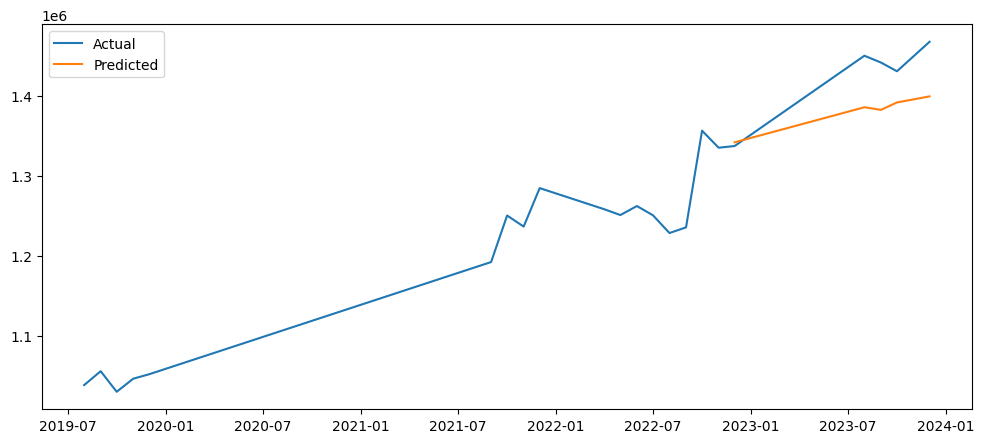

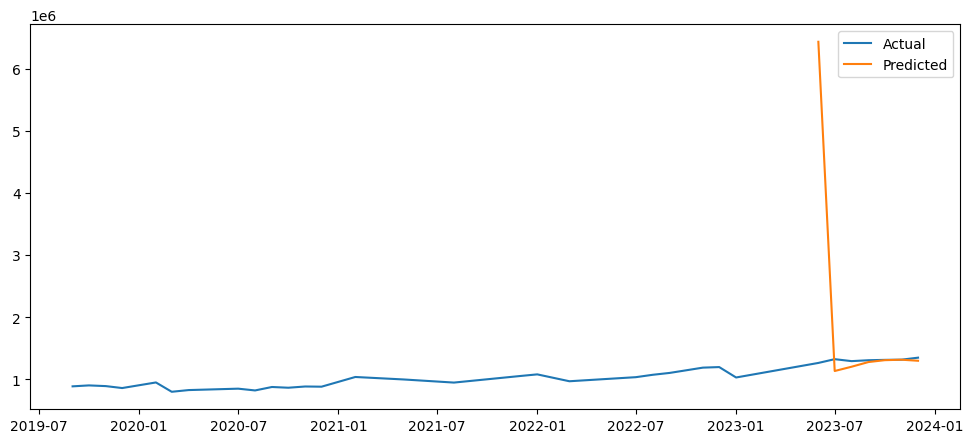

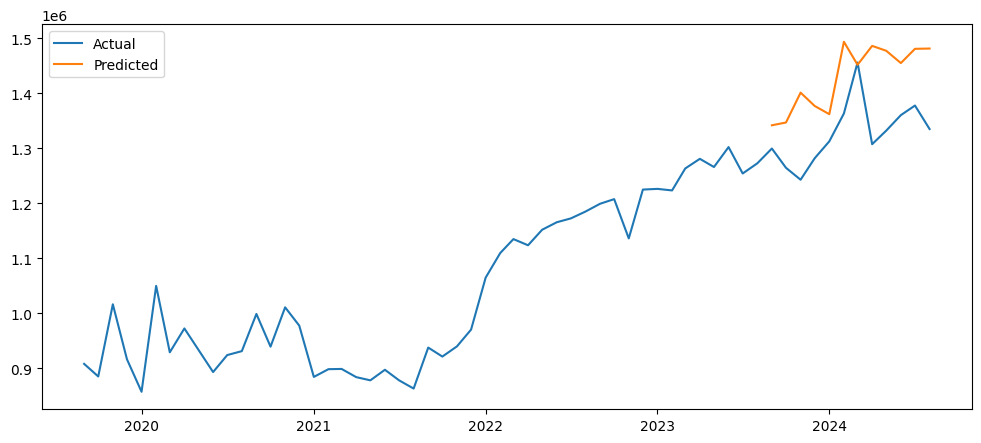

In [110]:
area_list = df['area'].unique()#[0:50] #for testing
year_after_lease_com_list = df['year_after_lease_com'].unique()

# Define the parameters for the Prophet model
seasonality = {
    'yearly': True,
    'weekly': False,
    'daily': False
}
start = time.time()
predictions = []
train_data = []
test_data = []
train_indices = []
metric_list = []
#mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
#experiment_id = mlflow.set_experiment("ec-price-experiment")

for area in area_list:
    for year_after_lease_com in year_after_lease_com_list:
        model_path = f'../models/model_area{area}_year{year_after_lease_com}.json'
        fig_path = f'../reports/figures/model_area{area}_year{year_after_lease_com}.png'
        df_select = prep_ec_data(df, area=area,year_after_lease_com=year_after_lease_com)#[['ds','y']]
        if len(df_select):
        
            predicted, df_train, df_test, train_index, rmse, mae = train_predict(
                df = df_select,
                train_fraction = 0.8,
                seasonality=seasonality,
                model_path=model_path
            )
            fig, ax = plt.subplots(1,1,figsize=(12,5))
            plt.plot(df_select.ds,df_select.y.values, label='Actual')
            plt.plot(df_test.ds,predicted.loc[:, 'yhat'], label='Predicted')
            plt.legend()
            plt.savefig(fig_path)
            #mlflow.log_figure(fig, f'predict_area{area}_year{year_after_lease_com}.png')
            #mlflow.log_metrics({'rmse':rmse})
            predictions.append(predicted)
            train_data.append(df_train)
            test_data.append(df_test)
            train_indices.append(train_index)
            metric_list.append({'area':area,'year_after_lease_com':year_after_lease_com,'rmse':rmse,'mae':mae})

        

    
serial_results = {
    'predictions': predictions,
    'train_data': train_data,
    'test_data': test_data,
    'train_indices': train_indices
}
df_metric = pd.DataFrame(metric_list)
df_metric.to_csv('../reports/testing_metric.csv')

In [111]:
df_select

,ds,y
